<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

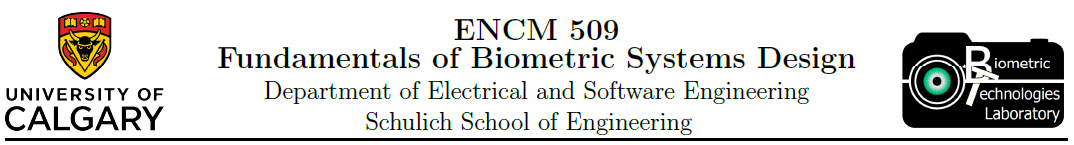

<center>
    <h1>Laboratory Experiment #4</h1>
    <h3>Fingerprint Biometrics - Part I: Preprocessing and Feature Extraction</h3>
</center>

In [1]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils_encm.poincare import calculate_singularities
from utils_encm.segmentation import segmentation
from utils_encm.normalization import normalize
from utils_encm.gabor_filter import gabor_filter
from utils_encm.frequency import ridge_freq
from utils_encm.orientation import calculate_angles, visualize_angles
from utils_encm.crossing_number import calculate_minutiae
from utils_encm.skeletonize import skeletonize
from utils_encm.MatchGaborFeat import MatchGaborFeat
from utils_encm.align2 import align2
from utils_encm.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

C:\Users\ahmad\AppData\Local\Temp\ipykernel_107536\1707584806.py:14: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener


## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
2. (10 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. Conclusion (a paragraph on what is the main take-out of the lab).

## Introduction

**The purpose of this lab is to get acquainted and experiment with different fingerprint image processing techniques. We collected a totol of 40 fingerprint images, 10 from Ali's right thumb, 10 from Ali's left thumb, 10 from Ahmed (Anwar's) right thumb and 10 from Ahmed (Anwar's) left index finger. In this lab we will be looking at the following image processing techniques: Normalization, Segmentation, Ridges Orientation Estimation, Ridge Frequency Estimation, Gabor Filtering, Thinning, Minutiae Detection and Singularities Detection. The lab will focus on the effect of histogram equalization, de-noising and changing the block size and threshold parameters of the segmentation step on the number of minutiae and singularities detected.**

**PART I (Lab 4): Specific Questions** 

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (3 marks): Select **two fingerprints of different quality (one good and one bad one) from two different fingers each (4 in total)**. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) by adding the **histogram equalization** step. For each fingerprint, perform all the pre-processing, and then add the histogram equalization. Compare the quantity of minutiae and singularities detected WITHOUT and WITH  the histogram equalization step. Record the number of minutiae, the number of singularities for each case. Draw the conclusions from this comparison.

**In exercise 1, we will be investigating the impact of histogram equalization by examining the minutiae counts and singularities of images with and without histogram equalization.**

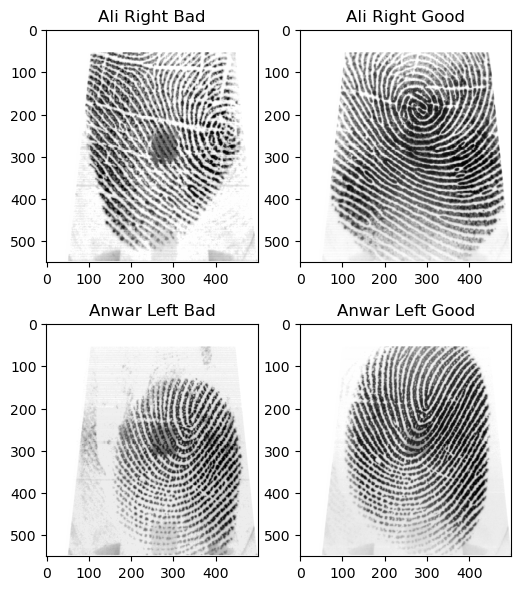

In [2]:
img_rb = img_as_ubyte(imread('fingerprints/ali_right/3.bmp', as_gray=True))
img_rg = img_as_ubyte(imread('fingerprints/ali_right/5.bmp', as_gray=True))
img_lb = img_as_ubyte(imread('fingerprints/anwar_left/5.bmp', as_gray=True))
img_lg = img_as_ubyte(imread('fingerprints/anwar_left/10.bmp', as_gray=True))

plt.figure(figsize=(6, 7))
plt.subplot(2, 2, 1)
plt.imshow(img_rb)
plt.title("Ali Right Bad")
plt.subplot(2, 2, 2)
plt.imshow(img_rg)
plt.title("Ali Right Good")
plt.subplot(2, 2, 3)
plt.imshow(img_lb)
plt.title("Anwar Left Bad")
plt.subplot(2, 2, 4)
plt.imshow(img_lg)
plt.title("Anwar Left Good")
plt.show()

In [3]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    # print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    # print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

In [4]:
img_rbeq = img_as_ubyte(equalize_adapthist(img_rb))
img_rgeq = img_as_ubyte(equalize_adapthist(img_rg))
img_lbeq = img_as_ubyte(equalize_adapthist(img_lb))
img_lgeq = img_as_ubyte(equalize_adapthist(img_lg))

fp_rb = fingerprint_processing(img_rb, block_size=16, threshold=0.2)        # Ali right Bad
fp_rbeq = fingerprint_processing(img_rbeq, block_size=16, threshold=0.2)    # Ali right Bad with histogram equalization

fp_rg = fingerprint_processing(img_rg, block_size=16, threshold=0.2)        # Ali right Good
fp_rgeq = fingerprint_processing(img_rgeq, block_size=16, threshold=0.2)    # Ali right Good with histogram equalization

fp_lb = fingerprint_processing(img_lb, block_size=16, threshold=0.2)        # Anwar left Bad
fp_lbeq = fingerprint_processing(img_lbeq, block_size=16, threshold=0.2)    # Anwar left Bad with histogram equalization

fp_lg = fingerprint_processing(img_lg, block_size=16, threshold=0.2)        # Anwar left Good
fp_lgeq = fingerprint_processing(img_lgeq, block_size=16, threshold=0.2)    # Anwar left Good with histogram equalization

print("Ali Right Thumb Bad Image")
print("WITHOUT Histogram Equalization - Minutiae: " + str(len(fp_rb['minutiae_lst'])) + " Singularities: " + str(len(fp_rb['singularities_lst'])))
print("WITH Histogram Equalization    - Minutiae: " + str(len(fp_rbeq['minutiae_lst'])) + " Singularities: " + str(len(fp_rbeq['singularities_lst'])))
print()

print("Ali Right Thumb Good Image")
print("WITHOUT Histogram Equalization - Minutiae: " + str(len(fp_rg['minutiae_lst'])) + " Singularities: " + str(len(fp_rg['singularities_lst'])))
print("WITH Histogram Equalization    - Minutiae: " + str(len(fp_rgeq['minutiae_lst'])) + " Singularities: " + str(len(fp_rgeq['singularities_lst'])))
print()

print("Anwar Left Index Bad Image")
print("WITHOUT Histogram Equalization - Minutiae: " + str(len(fp_lb['minutiae_lst'])) + " Singularities: " + str(len(fp_lb['singularities_lst'])))
print("WITH Histogram Equalization    - Minutiae: " + str(len(fp_lbeq['minutiae_lst'])) + " Singularities: " + str(len(fp_lbeq['singularities_lst'])))
print()

print("Anwar Left Index Good Image")
print("WITHOUT Histogram Equalization - Minutiae: " + str(len(fp_lg['minutiae_lst'])) + " Singularities: " + str(len(fp_lg['singularities_lst'])))
print("WITH Histogram Equalization    - Minutiae: " + str(len(fp_lgeq['minutiae_lst'])) + " Singularities: " + str(len(fp_lgeq['singularities_lst'])))
print()

Ali Right Thumb Bad Image
WITHOUT Histogram Equalization - Minutiae: 148 Singularities: 4
WITH Histogram Equalization    - Minutiae: 210 Singularities: 6

Ali Right Thumb Good Image
WITHOUT Histogram Equalization - Minutiae: 77 Singularities: 8
WITH Histogram Equalization    - Minutiae: 97 Singularities: 8

Anwar Left Index Bad Image
WITHOUT Histogram Equalization - Minutiae: 70 Singularities: 8
WITH Histogram Equalization    - Minutiae: 202 Singularities: 4

Anwar Left Index Good Image
WITHOUT Histogram Equalization - Minutiae: 46 Singularities: 4
WITH Histogram Equalization    - Minutiae: 50 Singularities: 4



## Exercise 1 Analysis

**We can see in all cases that using histogram equalization increases the number of minutiae counts, especially in the Bad quality images. We can also see that regardless of if histogram equalization was used or not, the minutiae count is lower in the Good quality images when compared to the Bad quality images. As for the singularities, we can see that using histogram equalization has no effect on the Good quality images, and has variable effect on the bad quality images where it increases the singularities count for Ali's right thumb, while decreasing the singularities count for Ahmed (Anwar's) bad quality left index finger image.**

- **Exercise 2** (3 marks): In this Exercise, perform the same steps as in exercise 1, but instead of histogram equalization, choose one **de-noising** method such as *Wiener* or *Median* filter. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) accordingly, record the outcomes and draw the conclusions. 

**In exercise 2, we will be applying a median filter to the images to investigate the impact of the filter by comparing the minutiae count and singulatiries of images before and after applying the filter.**

In [5]:
img_rbmed = median(img_rb)
img_rgmed = median(img_rg)
img_lbmed = median(img_lb)
img_lgmed = median(img_lg)

fp_rb = fingerprint_processing(img_rb, block_size=16, threshold=0.2)        # Ali right Bad
fp_rbmed = fingerprint_processing(img_rbmed, block_size=16, threshold=0.2)    # Ali right Bad with median filtering

fp_rg = fingerprint_processing(img_rg, block_size=16, threshold=0.2)        # Ali right Good
fp_rgmed = fingerprint_processing(img_rgmed, block_size=16, threshold=0.2)    # Ali right Good with median filtering

fp_lb = fingerprint_processing(img_lb, block_size=16, threshold=0.2)        # Anwar left Bad
fp_lbmed = fingerprint_processing(img_lbmed, block_size=16, threshold=0.2)    # Anwar left Bad with median filtering

fp_lg = fingerprint_processing(img_lg, block_size=16, threshold=0.2)        # Anwar left Good
fp_lgmed = fingerprint_processing(img_lgmed, block_size=16, threshold=0.2)    # Anwar left Good with median filtering

print("Ali Right Thumb Bad Image")
print("WITHOUT Median Filter - Minutiae: " + str(len(fp_rb['minutiae_lst'])) + " Singularities: " + str(len(fp_rb['singularities_lst'])))
print("WITH Median Filter    - Minutiae: " + str(len(fp_rbmed['minutiae_lst'])) + " Singularities: " + str(len(fp_rbmed['singularities_lst'])))
print()

print("Ali Right Thumb Good Image")
print("WITHOUT Median Filter - Minutiae: " + str(len(fp_rg['minutiae_lst'])) + " Singularities: " + str(len(fp_rg['singularities_lst'])))
print("WITH Median Filter    - Minutiae: " + str(len(fp_rgmed['minutiae_lst'])) + " Singularities: " + str(len(fp_rgmed['singularities_lst'])))
print()

print("Anwar Left Index Bad Image")
print("WITHOUT Median Filter - Minutiae: " + str(len(fp_lb['minutiae_lst'])) + " Singularities: " + str(len(fp_lb['singularities_lst'])))
print("WITH Median Filter    - Minutiae: " + str(len(fp_lbmed['minutiae_lst'])) + " Singularities: " + str(len(fp_lbmed['singularities_lst'])))
print()

print("Anwar Left Index Good Image")
print("WITHOUT Median Filter - Minutiae: " + str(len(fp_lg['minutiae_lst'])) + " Singularities: " + str(len(fp_lg['singularities_lst'])))
print("WITH Median Filter    - Minutiae: " + str(len(fp_lgmed['minutiae_lst'])) + " Singularities: " + str(len(fp_lgmed['singularities_lst'])))
print()

Ali Right Thumb Bad Image
WITHOUT Median Filter - Minutiae: 148 Singularities: 4
WITH Median Filter    - Minutiae: 115 Singularities: 4

Ali Right Thumb Good Image
WITHOUT Median Filter - Minutiae: 77 Singularities: 8
WITH Median Filter    - Minutiae: 81 Singularities: 8

Anwar Left Index Bad Image
WITHOUT Median Filter - Minutiae: 70 Singularities: 8
WITH Median Filter    - Minutiae: 67 Singularities: 4

Anwar Left Index Good Image
WITHOUT Median Filter - Minutiae: 46 Singularities: 4
WITH Median Filter    - Minutiae: 46 Singularities: 4



## Exercise 2 Analysis

**In this exercise, we applied a median filter on our images. We can see that the filter decreased the number of minutiae in Ali Right Thumb Bad Image by a decent amount and by a slight amount for Anwar Left Index Bad image. Whereas it increased for Ali Right Thumb Good image and stayed the same for Anwar Left Index Good Image. From this we observe that the filter helps with bad images but has little impact on good images**

- **Exercise 3** (4 marks): In this exercise, perform the same steps as in Exercise 1, but consider the **parameters `block_size` and `threshold`**. Evaluate the impact of these parameters by changing each of them to another value one at a time, for example: **change the `block_size` to 10 (`block_size = 10`) and keep the `threshold = 0.4`** (default). Second, **change the threshold only to `threshold = 0.5` while keeping the `block_size = 16`** (default). Evaluate  the number  of the detected minutiae and singularities. Compare the results and draw the conclusions.  

**In exercise 3, we will be investigating the impact of the variables "block_size" and "threshold" on images by examining the minutiae counts and singularities of images with different combinations**

In [33]:
# Original values
fp_rb_orig = fingerprint_processing(img_rb, block_size=16, threshold=0.2)        # Ali right Bad
fp_rg_orig = fingerprint_processing(img_rg, block_size=16, threshold=0.2)        # Ali right Good
fp_lb_orig = fingerprint_processing(img_lb, block_size=16, threshold=0.2)        # Anwar left Bad
fp_lg_orig = fingerprint_processing(img_lg, block_size=16, threshold=0.2)        # Anwar left Good

## Combination 1: block_size = 10, threshold = 0.2
fp_rb_comb1 = fingerprint_processing(img_rb, block_size=10, threshold=0.2)        # Ali right Bad 
fp_rg_comb1 = fingerprint_processing(img_rg, block_size=10, threshold=0.2)        # Ali right Good
fp_lb_comb1 = fingerprint_processing(img_lb, block_size=10, threshold=0.2)        # Anwar left Bad
fp_lg_comb1 = fingerprint_processing(img_lg, block_size=10, threshold=0.2)        # Anwar left Good

## Combination 2: block_size = 10, threshold = 0.5
fp_rb_comb2 = fingerprint_processing(img_rb, block_size=10, threshold=0.5)        # Ali right Bad 
fp_rg_comb2 = fingerprint_processing(img_rg, block_size=10, threshold=0.5)        # Ali right Good
fp_lb_comb2 = fingerprint_processing(img_lb, block_size=10, threshold=0.5)        # Anwar left Bad
fp_lg_comb2 = fingerprint_processing(img_lg, block_size=10, threshold=0.5)        # Anwar left Good

## Combination 3: block_size = 16, threshold = 0.1
fp_rb_comb3 = fingerprint_processing(img_rb, block_size=16, threshold=0.1)        # Ali right Bad 
fp_rg_comb3 = fingerprint_processing(img_rg, block_size=16, threshold=0.1)        # Ali right Good
fp_lb_comb3 = fingerprint_processing(img_lb, block_size=16, threshold=0.1)        # Anwar left Bad
fp_lg_comb3 = fingerprint_processing(img_lg, block_size=16, threshold=0.1)        # Anwar left Good

## Combination 4: block_size = 16, threshold = 0.1
fp_rb_comb4 = fingerprint_processing(img_rb, block_size=16, threshold=0.9)        # Ali right Bad 
fp_rg_comb4 = fingerprint_processing(img_rg, block_size=16, threshold=0.9)        # Ali right Good
fp_lb_comb4 = fingerprint_processing(img_lb, block_size=16, threshold=0.9)        # Anwar left Bad
fp_lg_comb4 = fingerprint_processing(img_lg, block_size=16, threshold=0.9)        # Anwar left Good

print("###################################################")
print("Original Values (block_size = 16, threshold = 0.2)")
print("Ali Right Thumb Bad Image")
print("Minutiae: " + str(len(fp_rb_orig['minutiae_lst'])) + " Singularities: " + str(len(fp_rb['singularities_lst'])))
print()

print("Ali Right Thumb Good Image")
print("Minutiae: " + str(len(fp_rg_orig['minutiae_lst'])) + " Singularities: " + str(len(fp_rg['singularities_lst'])))
print()

print("Anwar Left Index Bad Image")
print("Minutiae: " + str(len(fp_lb_orig['minutiae_lst'])) + " Singularities: " + str(len(fp_lb['singularities_lst'])))
print()

print("Anwar Left Index Good Image")
print("Minutiae: " + str(len(fp_lg_orig['minutiae_lst'])) + " Singularities: " + str(len(fp_lg['singularities_lst'])))
print("###################################################")

print("Combination 1: block_size = 10, threshold = 0.2")
print("Ali Right Thumb Bad Image")
print("Minutiae: " + str(len(fp_rb_comb1['minutiae_lst'])) + " Singularities: " + str(len(fp_rb['singularities_lst'])))
print()

print("Ali Right Thumb Good Image")
print("Minutiae: " + str(len(fp_rg_comb1['minutiae_lst'])) + " Singularities: " + str(len(fp_rg['singularities_lst'])))
print()

print("Anwar Left Index Bad Image")
print("Minutiae: " + str(len(fp_lb_comb1['minutiae_lst'])) + " Singularities: " + str(len(fp_lb['singularities_lst'])))
print()

print("Anwar Left Index Good Image")
print("Minutiae: " + str(len(fp_lg_comb1['minutiae_lst'])) + " Singularities: " + str(len(fp_lg['singularities_lst'])))
print("###################################################")

print("Combination 2: block_size = 10, threshold = 0.5")
print("Ali Right Thumb Bad Image")
print("Minutiae: " + str(len(fp_rb_comb2['minutiae_lst'])) + " Singularities: " + str(len(fp_rb['singularities_lst'])))
print()

print("Ali Right Thumb Good Image")
print("Minutiae: " + str(len(fp_rg_comb2['minutiae_lst'])) + " Singularities: " + str(len(fp_rg['singularities_lst'])))
print()

print("Anwar Left Index Bad Image")
print("Minutiae: " + str(len(fp_lb_comb2['minutiae_lst'])) + " Singularities: " + str(len(fp_lb['singularities_lst'])))
print()

print("Anwar Left Index Good Image")
print("Minutiae: " + str(len(fp_lg_comb2['minutiae_lst'])) + " Singularities: " + str(len(fp_lg['singularities_lst'])))
print("###################################################")

print("Combination 3: block_size = 16, threshold = 0.1")
print("Ali Right Thumb Bad Image")
print("Minutiae: " + str(len(fp_rb_comb3['minutiae_lst'])) + " Singularities: " + str(len(fp_rb['singularities_lst'])))
print()

print("Ali Right Thumb Good Image")
print("Minutiae: " + str(len(fp_rg_comb3['minutiae_lst'])) + " Singularities: " + str(len(fp_rg['singularities_lst'])))
print()

print("Anwar Left Index Bad Image")
print("Minutiae: " + str(len(fp_lb_comb3['minutiae_lst'])) + " Singularities: " + str(len(fp_lb['singularities_lst'])))
print()

print("Anwar Left Index Good Image")
print("Minutiae: " + str(len(fp_lg_comb3['minutiae_lst'])) + " Singularities: " + str(len(fp_lg['singularities_lst'])))
print("###################################################")

print("Combination 4: block_size = 16, threshold = 0.9")
print("Ali Right Thumb Bad Image")
print("Minutiae: " + str(len(fp_rb_comb4['minutiae_lst'])) + " Singularities: " + str(len(fp_rb['singularities_lst'])))
print()

print("Ali Right Thumb Good Image")
print("Minutiae: " + str(len(fp_rg_comb4['minutiae_lst'])) + " Singularities: " + str(len(fp_rg['singularities_lst'])))
print()

print("Anwar Left Index Bad Image")
print("Minutiae: " + str(len(fp_lb_comb4['minutiae_lst'])) + " Singularities: " + str(len(fp_lb['singularities_lst'])))
print()

print("Anwar Left Index Good Image")
print("Minutiae: " + str(len(fp_lg_comb4['minutiae_lst'])) + " Singularities: " + str(len(fp_lg['singularities_lst'])))
print("###################################################")

###################################################
Original Values (block_size = 16, threshold = 0.2)
Ali Right Thumb Bad Image
Minutiae: 148 Singularities: 4

Ali Right Thumb Good Image
Minutiae: 77 Singularities: 8

Anwar Left Index Bad Image
Minutiae: 70 Singularities: 8

Anwar Left Index Good Image
Minutiae: 46 Singularities: 4
###################################################
Combination 1: block_size = 10, threshold = 0.2
Ali Right Thumb Bad Image
Minutiae: 673 Singularities: 4

Ali Right Thumb Good Image
Minutiae: 819 Singularities: 8

Anwar Left Index Bad Image
Minutiae: 505 Singularities: 8

Anwar Left Index Good Image
Minutiae: 612 Singularities: 4
###################################################
Combination 2: block_size = 10, threshold = 0.5
Ali Right Thumb Bad Image
Minutiae: 520 Singularities: 4

Ali Right Thumb Good Image
Minutiae: 595 Singularities: 8

Anwar Left Index Bad Image
Minutiae: 274 Singularities: 8

Anwar Left Index Good Image
Minutiae: 450 Singularitie

## Exercise 3 Analysis
**From exercise 3, we can see that decreasing the blocksize from 16 to 10 while maintaining the threshold at 0.2 resulted in a significant increase in the number of minutiae. It had this effect on good and bad images alike. For example Ali's right thumb good image had its minutiae increase from 148 to 673. Singularities remained the same for all images between these 2 runs. Keeping the blocksize and 10 and then increasing the threshold to 0.5 from 0.2, we notice a decrease of about 1/4 in the minutiae for all images with the singularities remaining the same. Going back to a blocksize of 16 and changing the threshold to 0.1, we notice a slight increase for all images when comparing to a threshold of 0.1. Once again, keeping the blocksize at 16 and then changing the threshold to be 0.9, we see a big decrease in minutiae for all images. The singularities remained constant for all images.**

## Conclusion

**In this lab we explored the impact of a number of things on the number of minuatae and singularities of good and bad quality images. First we looked at the impact of histogram equalization. We noticed that histogram equalization seemed to increase the number of minutiae counts in all images (both good quality and bad quality). We also noticed that for good images, histogram equalization has no effect on singularities and can have a variable effect on bad images. Next, we explored the impact of adding a filter. We used a median filter and observed that it decreased the number of minutiae for bad images and only impacted the singualirities' of one bad image. However, the filter had little to no impact on the good images minutiae count. Finally, we investigated the effect of changing the blocksize and threshold variables. We had 5 combinations (including the default one). From this, we noticed that decreasing block size increases the number of minutiae significantly. For example when we reduced it from 16 to 10, the minuatiae count for one of the images jumped from 148 to 673. From exercise 3 we also observed that increasing the threshold results in fewer minutiae while decreasing the threshold results in more minutiae.**
